In [1]:
import os

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import pandas as pd
import scikit_posthocs as sp
import scipy.stats as stats
from termcolor import colored

In [2]:
cwd = os.getcwd()
benchmark_result_path = os.path.realpath(os.path.join(cwd, "../data/app-results.csv"))

print(benchmark_result_path)

/Users/csalih/Developer/bsc-web-benchmark/benchmark/benchmark-analyze/data/app-results.csv


In [3]:
# Load the dataset
csv_headers = ["framework", "metric", "os", "browser", "value"]
df = pd.read_csv(benchmark_result_path, header=None, names=csv_headers)

df['value'] = pd.to_numeric(df['value'], errors='raise')

# Group the data
frameworks = df["framework"].unique()
metrics = df["metric"].unique()
browsers = df["browser"].unique()
operating_systems = df["os"].unique()

df_by_framework = df.groupby("framework")
df_by_metric = df.groupby("metric")

# Display basic info
pd.concat([df.head(5), df.tail(5)])

,framework,metric,os,browser,value
0,app-angular,create_1000_duration,darwin,chromium,56.2
1,app-angular,create_10000_duration,darwin,chromium,558.3
2,app-angular,append_1000_rows_duration,darwin,chromium,60.6
3,app-angular,update_every_10th_row_duration,darwin,chromium,4.6
4,app-angular,swap_rows_duration,darwin,chromium,10.3
17995,app-leptos,create_1000_duration,win32,webkit,332.0
17996,app-leptos,create_10000_duration,win32,webkit,4199.0
17997,app-leptos,append_1000_rows_duration,win32,webkit,319.0
17998,app-leptos,update_every_10th_row_duration,win32,webkit,41.0
17999,app-leptos,swap_rows_duration,win32,webkit,64.0


In [4]:
# Validate

# Check if there is sufficient data
if (
  df["framework"].nunique() < 0
  or df["browser"].nunique() < 0
  or df["os"].nunique() < 0
):
  raise Exception(f"Data has insufficient data.")

# Group by all factors and count the number of observations
counts = (
  df.groupby(["framework", "metric", "browser", "os"])
  .size()
  .reset_index(name="count")
)
single_observations = counts[counts["count"] == 1]

if not single_observations.empty:
  print("WARNING: The following groups have only one observation. ANOVA may fail:")
  print(single_observations)
  raise Exception("Consider combining levels or simplifying your model.")

In [5]:
for metric in metrics:
  data = df
  data = data[data.metric.eq(metric)]

  # Group by (browser, os) and compute descriptive statistics
  summary = data.groupby(['browser', 'os'])['value'].describe().map(lambda x: f"{x:0.2f}")

  # Convert to a clean format
  summary.index = [f"{b.capitalize()} ({o.capitalize()})" for b, o in summary.index]

  # Compute total row
  total_row = data['value'].describe().apply("{0:.2f}".format).to_frame().T
  total_row.index = ["Total"]
  summary = pd.concat([summary, total_row])

  # Rename columns for better readability
  summary = summary.drop(columns=['25%'])
  summary = summary.rename(columns={
    'count': 'Count', 'mean': 'Mean', 'std': 'Std',
    'min': 'Min', '50%': '50%', '75%': '75%', 'max': 'Max'
  })

  # Print the final summary
  print(colored("######################################################################", "light_blue"))
  print(colored(f"Results for Metric: {metric}", "light_blue"))
  print(colored("######################################################################", "light_blue"))
  print("")
  display(summary)

######################################################################
Results for Metric: create_1000_duration
######################################################################



,Count,Mean,Std,Min,50%,75%,Max
Chromium (Darwin),400.00,57.64,2.67,53.30,57.85,59.30,68.80
Chromium (Linux),400.00,217.89,14.13,196.80,220.10,228.00,367.60
Chromium (Win32),400.00,272.56,23.23,219.90,271.75,282.75,420.90
Firefox (Darwin),400.00,44.82,6.41,35.00,44.00,49.25,57.00
Firefox (Linux),400.00,155.85,30.57,116.00,152.50,187.25,415.00
Firefox (Win32),400.00,242.77,49.33,154.00,233.00,286.25,376.00
Webkit (Darwin),400.00,54.92,4.33,49.00,54.00,57.75,65.00
Webkit (Linux),400.00,254.82,15.03,227.00,258.50,267.00,286.00
Webkit (Win32),400.00,389.97,55.35,299.00,396.00,407.25,1011.00
Total,3600.00,187.91,115.48,35.00,206.20,264.00,1011.00


######################################################################
Results for Metric: create_10000_duration
######################################################################



,Count,Mean,Std,Min,50%,75%,Max
Chromium (Darwin),400.00,577.96,38.40,521.00,575.10,608.05,651.90
Chromium (Linux),400.00,2091.86,104.07,1884.90,2133.65,2156.73,2592.80
Chromium (Win32),400.00,2458.97,169.50,2243.20,2468.20,2511.25,4160.50
Firefox (Darwin),400.00,432.88,90.41,316.00,435.50,520.00,547.00
Firefox (Linux),400.00,1369.46,300.15,987.00,1502.50,1694.25,2417.00
Firefox (Win32),400.00,1673.90,257.28,1276.00,1702.00,1949.00,2189.00
Webkit (Darwin),400.00,821.43,60.73,743.00,831.00,877.00,914.00
Webkit (Linux),400.00,4442.00,882.47,2449.00,4781.00,4981.25,5263.00
Webkit (Win32),400.00,5732.78,1594.63,3737.00,5284.50,7964.75,8665.00
Total,3600.00,2177.92,1817.58,316.00,1740.50,2490.00,8665.00


######################################################################
Results for Metric: append_1000_rows_duration
######################################################################



,Count,Mean,Std,Min,50%,75%,Max
Chromium (Darwin),400.00,58.10,4.61,52.90,55.75,63.50,69.20
Chromium (Linux),400.00,225.29,24.20,195.80,211.35,250.10,313.60
Chromium (Win32),400.00,254.18,36.34,214.00,247.75,276.70,547.50
Firefox (Darwin),400.00,44.74,8.62,33.00,41.00,55.00,65.00
Firefox (Linux),400.00,145.30,30.30,110.00,131.00,188.00,239.00
Firefox (Win32),400.00,160.79,28.19,119.00,155.00,186.00,263.00
Webkit (Darwin),400.00,62.58,4.85,57.00,61.00,64.50,72.00
Webkit (Linux),400.00,277.07,15.02,253.00,273.50,289.25,381.00
Webkit (Win32),400.00,395.12,47.20,302.00,406.00,421.25,764.00
Total,3600.00,180.35,114.49,33.00,186.00,264.08,764.00


######################################################################
Results for Metric: update_every_10th_row_duration
######################################################################



,Count,Mean,Std,Min,50%,75%,Max
Chromium (Darwin),400.00,5.53,1.89,3.90,5.10,5.60,14.50
Chromium (Linux),400.00,23.75,6.78,14.10,21.45,30.00,35.60
Chromium (Win32),400.00,25.45,7.52,16.50,23.40,32.95,67.00
Firefox (Darwin),400.00,5.55,2.80,3.00,5.00,6.00,29.00
Firefox (Linux),400.00,15.46,2.97,11.00,15.00,17.25,36.00
Firefox (Win32),400.00,16.10,4.00,10.00,15.00,17.00,40.00
Webkit (Darwin),400.00,9.34,1.98,6.00,10.00,11.00,18.00
Webkit (Linux),400.00,46.26,9.93,24.00,46.00,53.00,70.00
Webkit (Win32),400.00,82.02,18.58,41.00,86.00,96.00,125.00
Total,3600.00,25.50,24.63,3.00,16.10,32.52,125.00


######################################################################
Results for Metric: swap_rows_duration
######################################################################



,Count,Mean,Std,Min,50%,75%,Max
Chromium (Darwin),400.00,19.13,17.90,5.10,10.40,23.50,54.30
Chromium (Linux),400.00,61.89,70.34,18.50,21.60,72.15,194.50
Chromium (Win32),400.00,72.87,84.51,21.90,24.80,87.67,340.20
Firefox (Darwin),400.00,22.80,11.98,12.00,17.50,30.50,46.00
Firefox (Linux),400.00,60.33,36.21,33.00,42.50,91.75,128.00
Firefox (Win32),400.00,67.37,40.06,32.00,48.00,90.50,158.00
Webkit (Darwin),400.00,26.48,25.21,10.00,13.00,32.75,72.00
Webkit (Linux),400.00,109.50,96.89,40.00,55.00,135.25,314.00
Webkit (Win32),400.00,167.91,159.13,56.00,82.00,348.00,472.00
Total,3600.00,67.59,87.36,5.10,40.00,70.00,472.00


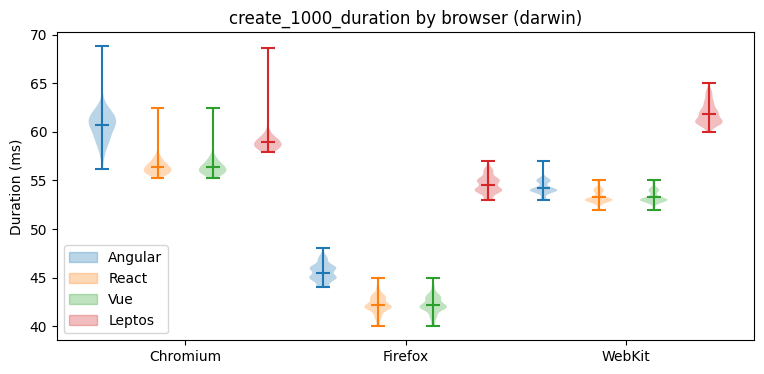

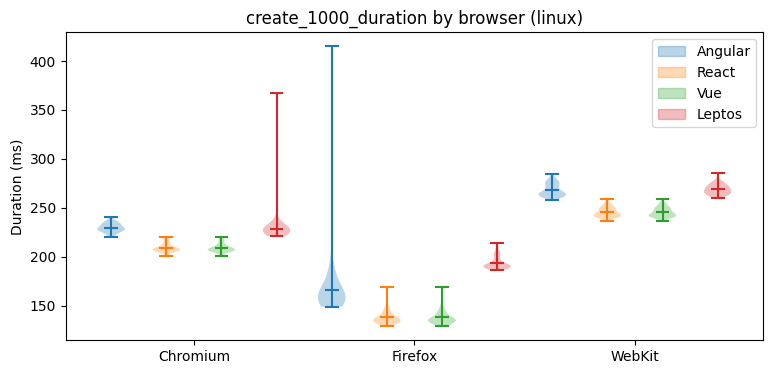

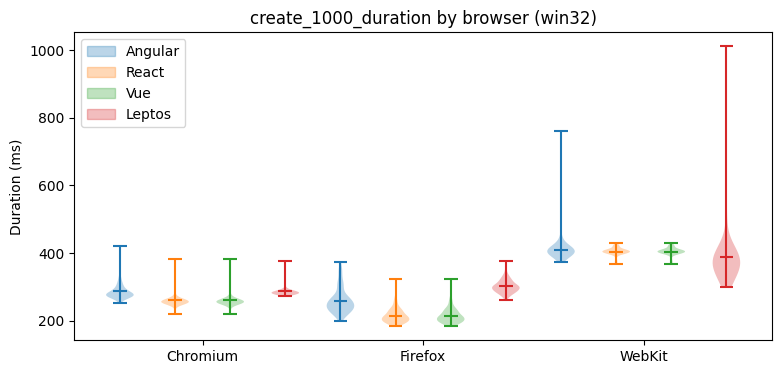

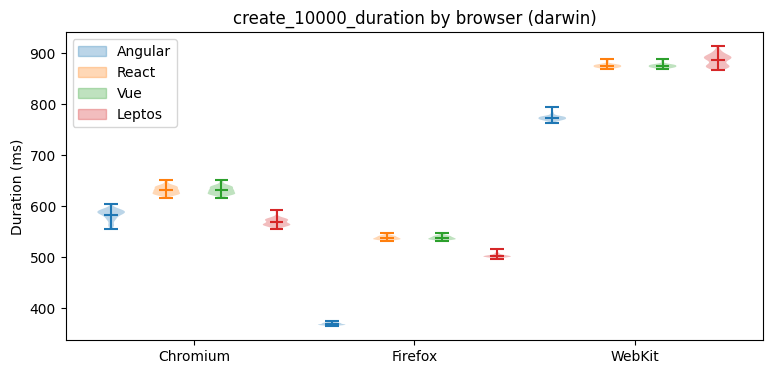

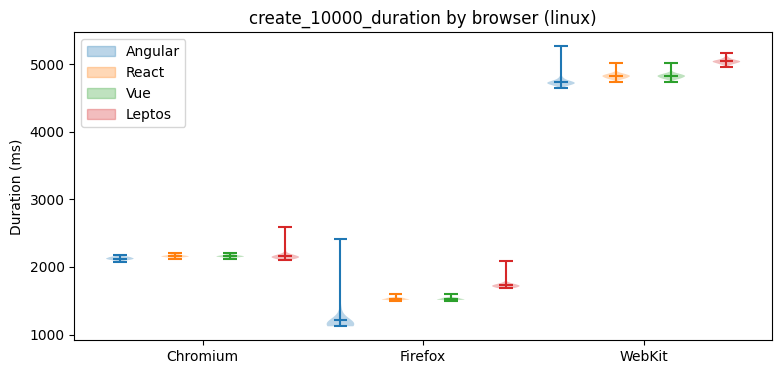

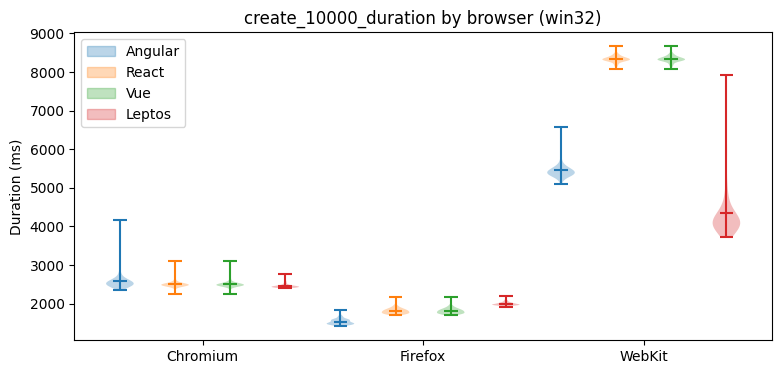

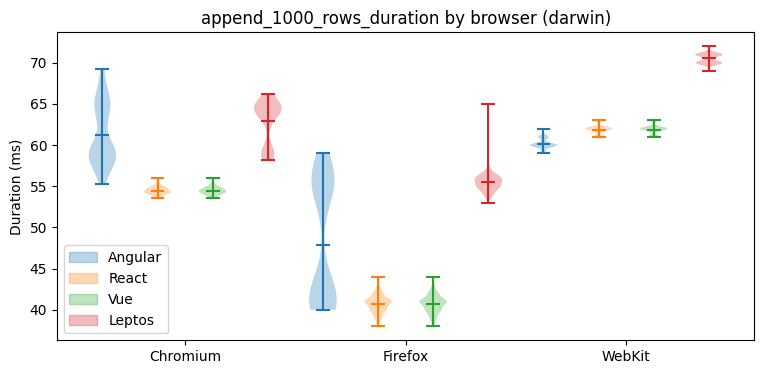

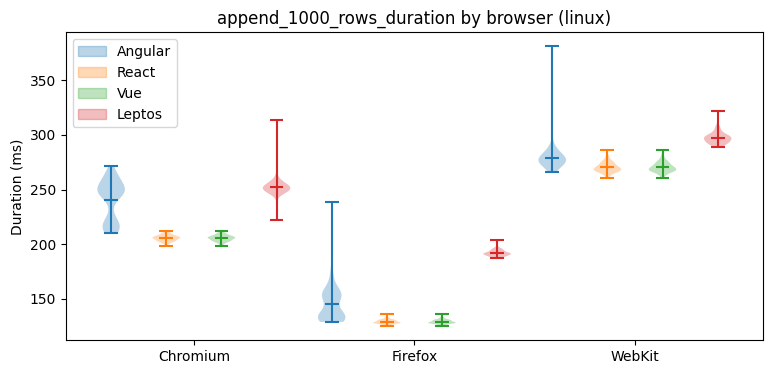

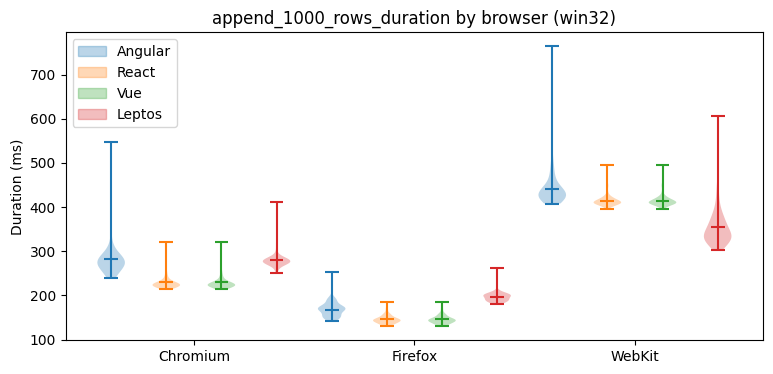

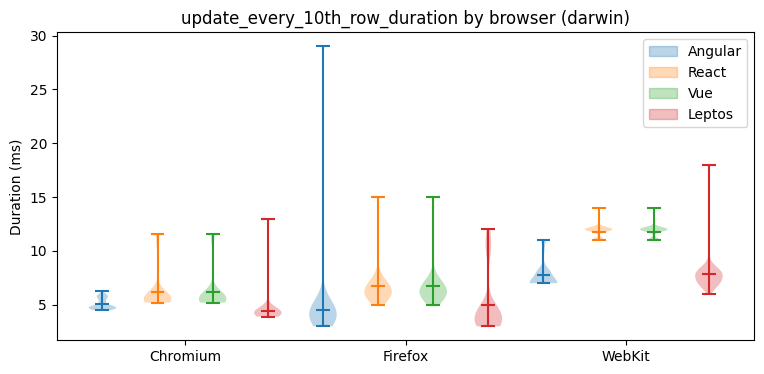

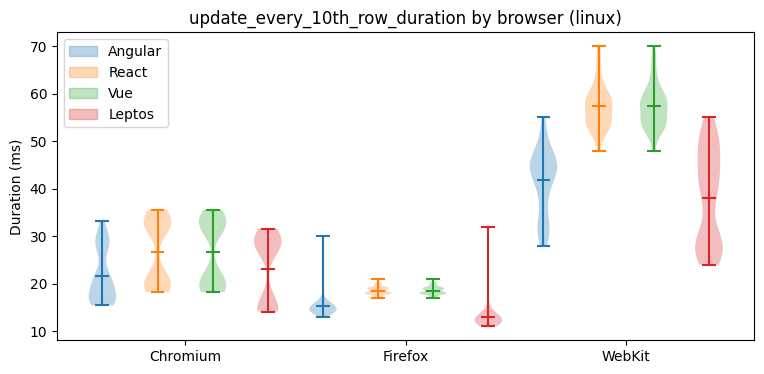

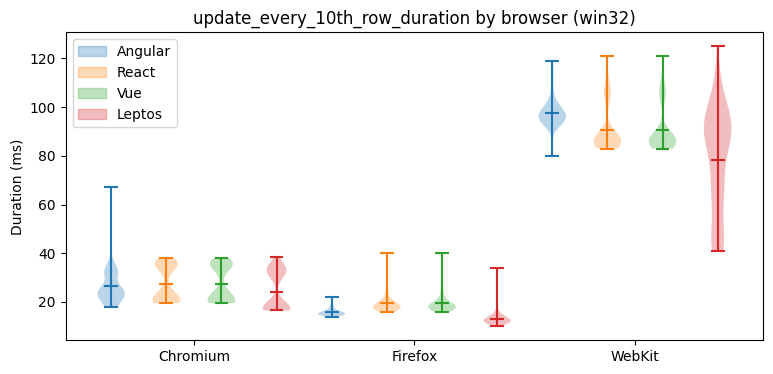

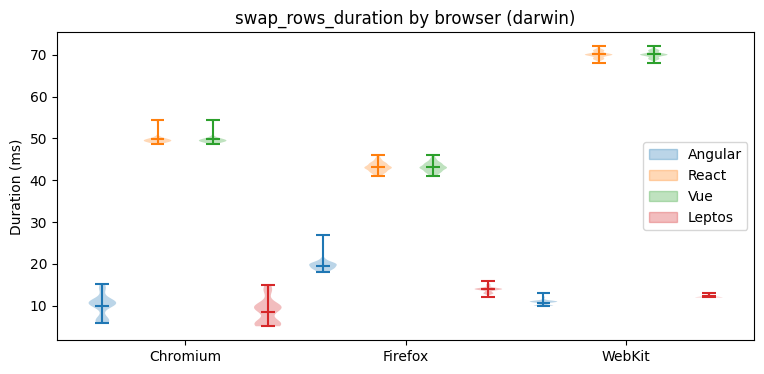

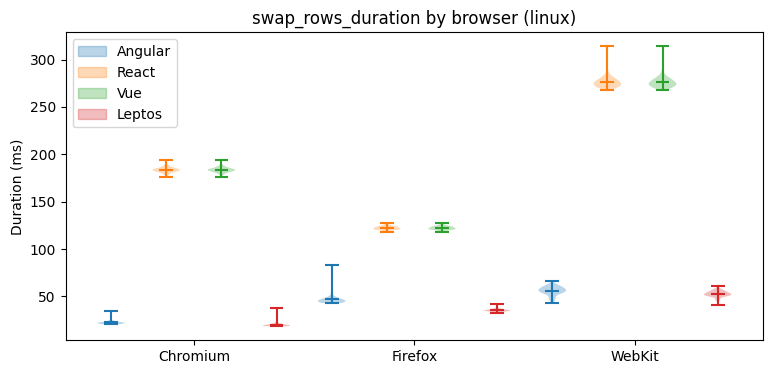

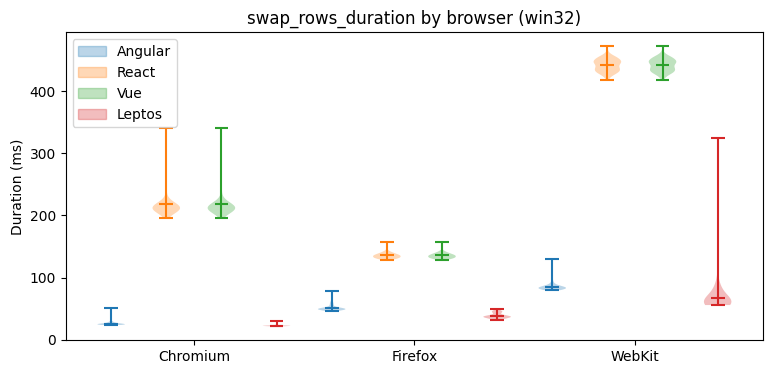

In [6]:
for metric in metrics:
  for idx_os, os in enumerate(operating_systems):
    labels = []


    def add_label(violin, label):
      color = violin["bodies"][0].get_facecolor().flatten()
      labels.append((mpatches.Patch(color=color), label))


    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9, 4))

    subset = df
    subset = subset[subset.os.eq(os)]
    subset = subset[subset.metric.eq(metric)]

    positions = [[1, 5, 9], [2, 6, 10], [3, 7, 11], [4, 8, 12]]

    # Conduit Angular
    data = subset[subset.framework.eq("app-angular")]
    durations = [group['value'] for _, group in data.groupby(['browser'])]
    rects = ax.violinplot(durations, positions[0], showmeans=True, showmedians=False)
    add_label(rects, "Angular")

    # Conduit React
    data = subset[subset.framework.eq("app-react")]
    durations = [group['value'] for _, group in data.groupby(['browser'])]
    rects = ax.violinplot(durations, positions[1], showmeans=True, showmedians=False)
    add_label(rects, "React")

    data = subset[subset.framework.eq("app-react")]
    durations = [group['value'] for _, group in data.groupby(['browser'])]
    rects = ax.violinplot(durations, positions[2], showmeans=True, showmedians=False)
    add_label(rects, "Vue")

    data = subset[subset.framework.eq("app-leptos")]
    durations = [group['value'] for _, group in data.groupby(['browser'])]
    rects = ax.violinplot(durations, positions[3], showmeans=True, showmedians=False)
    add_label(rects, "Leptos")

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_title(f'{metric} by browser ({os})')
    ax.set_ylabel('Duration (ms)')
    ax.set_xticks([2.5, 6.5, 10.5], ["Chromium", "Firefox", "WebKit"])

    # Legend
    ax.legend(*zip(*labels))

    plt.show()
    ax.set_title("")
    fig.savefig(f"output/{metric}_{os}.pdf")


In [13]:
# Combine OS and Browser into a single column
df['browser_os'] = df['browser'] + " (" + df['os'] + ")"

# Store Kruskal-Wallis results
kruskal_results = []
posthoc_results_kruskal = {}
friedman_results = []
posthoc_results_friedman = {}
mean_ranks = {}
mean_ranks_browser = {}

# 1️⃣ Kruskal-Wallis Test & Dunn's Post Hoc if Significant
for metric in df['metric'].unique():
  subset = df[df['metric'] == metric]
  groups = [subset[subset['framework'] == fw]['value'].values for fw in subset['framework'].unique()]

  # Kruskal-Wallis Test
  stat, p = stats.kruskal(*groups)
  kruskal_results.append({'Metric': metric, 'H-stat': stat, 'p-value': p})

  # If significant, perform Dunn’s post hoc test
  if p < 0.05:
    posthoc = sp.posthoc_dunn(subset, val_col='value', group_col='framework')
    posthoc_results_kruskal[metric] = posthoc

# Step 2: Check Browser Impact Using Friedman Test
df_agg = df.groupby(['framework', 'browser', 'metric'])['value'].mean().reset_index()
for metric in metrics:
  subset = df_agg[df_agg['metric'] == metric]
  pivot_table = subset.pivot(index='framework', columns='browser', values='value')

  # Ensure enough data
  if pivot_table.shape[1] != 3:
    raise Exception(f"Insufficient data for metric {metric}! Must have 3 browsers.")

  stat, p = stats.friedmanchisquare(*pivot_table.T.values)
  friedman_results.append({'Metric': metric, 'F-stat': stat, 'p-value': p})

  # If significant, perform Nemenyi post hoc test
  if p < 0.05:
    posthoc = sp.posthoc_nemenyi_friedman(pivot_table)
    posthoc_results_friedman[metric] = posthoc

  # Step 3: Compute Mean Rank Differences for Ranking Frameworks
  mean_ranks_browser[metric] = pivot_table.rank(axis=1, method='average').mean().sort_values()

# 3️⃣ Compute Mean Rank Differences for Ranking Frameworks
mean_ranks = df.groupby(['framework', 'metric'])['value'].mean().reset_index()
mean_ranks['rank'] = mean_ranks.groupby('metric')['value'].rank(method='average')

# Convert results to DataFrames
kruskal_df = pd.DataFrame(kruskal_results)
friedman_df = pd.DataFrame(friedman_results)
mean_ranks_df = pd.DataFrame(mean_ranks)
mean_ranks_browser_df = pd.DataFrame(mean_ranks_browser)

# 📌 Print Results
print("\n=== Kruskal-Wallis Test Results ===")
print(kruskal_df)

print("\n=== Mean Rank Comparison ===")
print(mean_ranks_df)

print("\n=== Friedman Test Results (Browser Impact) ===")
print(friedman_df)

# 📌 Post Hoc Results
print("\n=== Dunn’s Post Hoc (For Significant Kruskal Tests) ===")
for metric, result in posthoc_results_kruskal.items():
  print(f"\n📌 Dunn’s Test for Metric: {metric}")
  print(result)
  print(result < 0.05)

print("\n=== Nemenyi Post Hoc (For Significant Friedman Tests) ===")
for metric, result in posthoc_results_friedman.items():
  print(f"\n📌 Nemenyi Test for Metric: {metric}")
  print(result)

print("\n=== Mean Rank Comparison Browser ===")
display(mean_ranks_browser_df)


=== Kruskal-Wallis Test Results ===
                           Metric       H-stat       p-value
0            create_1000_duration   145.492716  2.471574e-31
1           create_10000_duration    59.743158  6.669870e-13
2       append_1000_rows_duration   110.684567  7.816405e-24
3  update_every_10th_row_duration    80.717268  2.153649e-17
4              swap_rows_duration  1520.012135  0.000000e+00

=== Mean Rank Comparison ===
      framework                          metric        value  rank
0   app-angular       append_1000_rows_duration   191.588889   3.0
1   app-angular           create_10000_duration  2149.885444   2.0
2   app-angular            create_1000_duration   198.058889   3.0
3   app-angular              swap_rows_duration    36.502111   3.0
4   app-angular  update_every_10th_row_duration    26.214778   3.0
5    app-leptos       append_1000_rows_duration   195.970444   4.0
6    app-leptos           create_10000_duration  2188.003000   3.0
7    app-leptos            crea

,create_1000_duration,create_10000_duration,append_1000_rows_duration,update_every_10th_row_duration,swap_rows_duration
browser,,,,,
chromium,2.0,2.0,2.0,2.0,1.25
firefox,1.0,1.0,1.0,1.0,1.75
webkit,3.0,3.0,3.0,3.0,3.00
